# Beach Crowd Detection - Adaptive Gamma Edition

This notebook provides **extensive analytical tools** to understand beach images and select optimal detection techniques.

## 🆕 Adaptive Gamma Correction

This version includes **automatic brightness normalization** that adapts to each image's lighting conditions:

- **Problem**: Fixed gamma values fail when images have varying lighting (dark/overcast vs bright/sunny)
- **Solution**: Dynamically calculate gamma based on image median brightness to achieve a consistent target

**How it works:**
```
target_brightness = 140 (default, works well for beach sand)
current_brightness = median(grayscale_image)
gamma = log(target/255) / log(current/255)
```

**Benefits:**
- HSV sand filters work consistently across all lighting conditions
- No manual gamma tuning required per image
- More robust detection in mixed lighting datasets



## 1. Import Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from scipy import ndimage
from skimage import feature, filters
from skimage.measure import shannon_entropy
import os
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
import warnings
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, VBox, HBox, Tab
import json

warnings.filterwarnings('ignore')

# Set matplotlib to display inline
%matplotlib inline
plt.rcParams['figure.max_open_warning'] = 0

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 2. Utility Functions

In [2]:
def adjust_gamma(image, gamma=None, target_brightness=160.0):
    """
    Apply gamma correction - ADAPTIVE if gamma is None.
    
    Simple/Fast approach: Uses image median to calculate gamma needed
    to reach target_brightness. Works well across varying lighting conditions.
    
    Math: output = input^gamma
          gamma = log(target/255) / log(current/255)
    
    Args:
        image: Input RGB image
        gamma: If provided, use fixed gamma. If None, calculate adaptively.
        target_brightness: Target median brightness (0-255) when adaptive.
    
    Returns:
        Tuple of (corrected_image, gamma_used) if adaptive, else just corrected_image
    """
    if gamma is not None:
        # Fixed gamma mode (backward compatible)
        img = image.astype(np.float32) / 255.0
        img = np.power(img, gamma)
        return np.clip(img * 255.0, 0, 255).astype(np.uint8)
    
    # ADAPTIVE GAMMA: Calculate based on image median
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    
    # Use median (50th percentile) - robust to outliers like bright sky or dark shadows
    current_brightness = np.percentile(gray, 50)
    
    # Avoid log(0) and division issues
    current_brightness = np.clip(current_brightness, 1, 254)
    target_brightness = np.clip(target_brightness, 1, 254)
    
    # Calculate gamma: gamma = log(target_norm) / log(current_norm)
    current_norm = current_brightness / 255.0
    target_norm = target_brightness / 255.0
    calculated_gamma = np.log(target_norm) / np.log(current_norm)
    
    # Clamp to reasonable range to avoid extreme corrections
    calculated_gamma = np.clip(calculated_gamma, 0.2, 3.0)
    
    # Apply gamma correction
    img = image.astype(np.float32) / 255.0
    img = np.power(img, calculated_gamma)
    corrected = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    
    return corrected, calculated_gamma


def calculate_mae(detected_count: int, ground_truth_count: int) -> int:
    """Calculate Mean Absolute Error."""
    return abs(detected_count - ground_truth_count)


def calculate_image_statistics(image):
    """Calculate comprehensive image statistics."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    
    stats = {
        'mean': np.mean(gray),
        'std': np.std(gray),
        'min': np.min(gray),
        'max': np.max(gray),
        'median': np.median(gray),
        'entropy': shannon_entropy(gray),
        'contrast': np.max(gray) - np.min(gray),
        'brightness_category': 'Dark' if np.mean(gray) < 85 else 'Medium' if np.mean(gray) < 170 else 'Bright',
        'contrast_category': 'Low' if (np.max(gray) - np.min(gray)) < 100 else 'Medium' if (np.max(gray) - np.min(gray)) < 180 else 'High'
    }
    return stats


def detect_edges(image):
    """Detect edges using multiple methods."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    
    # Canny edge detection
    canny = cv2.Canny(gray, 50, 160)
    
    # Sobel edge detection
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = np.uint8(255 * sobel / np.max(sobel))
    
    return {'canny': canny, 'sobel': sobel}


def calculate_local_variance(image, window_size=15):
    """Calculate local variance to detect texture."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    
    # Calculate mean
    mean = cv2.blur(gray.astype(float), (window_size, window_size))
    
    # Calculate variance
    sqr_mean = cv2.blur((gray.astype(float))**2, (window_size, window_size))
    variance = sqr_mean - mean**2
    
    return variance

LIMIT_POLYGON = None  # global/shared polygon


def load_limit_polygon(json_path: str) -> np.ndarray:
    with open(json_path, "r") as f:
        data = json.load(f)

    # Just take the first entry, ignore the actual filename
    first_item = next(iter(data.values()))
    regions = first_item["regions"]
    first_region = regions[next(iter(regions))]

    shape = first_region["shape_attributes"]
    xs = shape["all_points_x"]
    ys = shape["all_points_y"]

    pts = np.array(list(zip(xs, ys)), dtype=np.int32)
    return pts


# Call this once at startup / before processing all images
LIMIT_POLYGON = load_limit_polygon("limit_coordinates.json")
def apply_limit_mask(image, polygon=LIMIT_POLYGON):
    if polygon is None:
        return image

    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [polygon], 255)
    masked = cv2.bitwise_and(image, image, mask=mask)
    return masked
print("✓ Utility functions loaded")


✓ Utility functions loaded


## 3. Analytical Functions

In [3]:
def analyze_color_spaces(image):
    """Analyze image in multiple color spaces."""
    # RGB
    rgb_means = [np.mean(image[:,:,i]) for i in range(3)]
    rgb_stds = [np.std(image[:,:,i]) for i in range(3)]
    
    # HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_means = [np.mean(hsv[:,:,i]) for i in range(3)]
    hsv_stds = [np.std(hsv[:,:,i]) for i in range(3)]
    
    # LAB
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    lab_means = [np.mean(lab[:,:,i]) for i in range(3)]
    lab_stds = [np.std(lab[:,:,i]) for i in range(3)]
    
    return {
        'rgb': {'means': rgb_means, 'stds': rgb_stds},
        'hsv': {'means': hsv_means, 'stds': hsv_stds},
        'lab': {'means': lab_means, 'stds': lab_stds}
    }


def otsu_analysis(image, roi_sand_only=False, hsv_s_max=50, hsv_v_min=100):
    """Perform Otsu threshold analysis."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    
    if roi_sand_only:
        # Apply HSV filter to get sand regions
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        mask_sand = (hsv[:, :, 1] < hsv_s_max) & (hsv[:, :, 2] > hsv_v_min)
        gray_roi = gray.copy()
        gray_roi[~mask_sand] = 0
        # Calculate Otsu on sand pixels only
        sand_pixels = gray[mask_sand]
        if len(sand_pixels) > 0:
            otsu_threshold, _ = cv2.threshold(sand_pixels, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        else:
            otsu_threshold = 127
        _, otsu_result = cv2.threshold(gray_roi, otsu_threshold, 255, cv2.THRESH_BINARY)
    else:
        # Global Otsu
        otsu_threshold, otsu_result = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return {
        'threshold': otsu_threshold,
        'result': otsu_result,
        'gray': gray
    }


print("✓ Analytical functions loaded")

✓ Analytical functions loaded


## 4. Pipeline Processing Functions

In [4]:
def load_image(image_path):
    """Load image from path."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def apply_clahe(image, clip_limit=2.0):
    """Apply CLAHE enhancement."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    clahe_gray = clahe.apply(gray)
    clahe_rgb = cv2.cvtColor(clahe_gray, cv2.COLOR_GRAY2RGB)
    return clahe_rgb, clahe_gray


def apply_preprocessing(
    image,
    target_brightness=160.0,  
    gamma=None,               # Optional: override with fixed gamma
    gaussian_size=5,
    top_mask_percent=0.40,
    hsv_s_max=50,
    hsv_v_min=100,
    morph_size=5,
    adaptive_block_size=11,
    adaptive_c=2,
):
    """
    Preprocessing pipeline with ADAPTIVE gamma correction.
    
    The key insight: normalize image brightness BEFORE applying HSV filters,
    so the thresholds work consistently across all lighting conditions.
    
    Args:
        image: Input RGB image
        target_brightness: Target median brightness (160 works well for beach sand)
        gamma: If provided, use fixed gamma instead of adaptive
        ... (other params unchanged)
    """
    # # STEP 1: Top mask
    # h = image.shape[0]
    # mask_height = int(h * top_mask_percent)
    # top_masked = image.copy()
    # top_masked[:mask_height, :] = [128, 128, 128]

    top_masked = apply_limit_mask(image)

    

    # STEP 2: ADAPTIVE GAMMA (the key change!)
    gamma_result = adjust_gamma(top_masked, gamma=gamma, target_brightness=target_brightness)
    
    # Handle both return formats (tuple for adaptive, single value for fixed)
    if isinstance(gamma_result, tuple):
        gamma_img, gamma_used = gamma_result
    else:
        gamma_img = gamma_result
        gamma_used = gamma if gamma is not None else "N/A"

    # STEP 3: Gaussian blur
    if gaussian_size > 0:
        blurred = cv2.GaussianBlur(gamma_img, (gaussian_size, gaussian_size), 0)
    else:
        blurred = gamma_img.copy()

    # STEP 4: HSV sand mask (now works consistently due to normalized brightness!)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
    mask_sand = (hsv[:, :, 1] < hsv_s_max) & (hsv[:, :, 2] > hsv_v_min)

    sand_mask_vis = np.zeros_like(blurred)
    sand_mask_vis[mask_sand] = blurred[mask_sand]

    non_sand_mask_vis = np.zeros_like(blurred)
    non_sand_mask_vis[~mask_sand] = blurred[~mask_sand]

    # STEP 5: remove sand (keep non-sand)
    non_sand_only = blurred.copy()
    non_sand_only[mask_sand] = [0, 0, 0]

    # STEP 6: grayscale on non-sand
    gray = cv2.cvtColor(non_sand_only, cv2.COLOR_RGB2GRAY)

    # STEP 7: morphology (opening -> closing)
    kernel = np.ones((morph_size, morph_size), np.uint8)
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    morph = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    # Optional HSV visualization (sand only)
    hsv_filtered = blurred.copy()
    hsv_filtered[~mask_sand] = [0, 0, 0]

    # STEP 8: thresholding
    binary = cv2.adaptiveThreshold(
        morph,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        adaptive_block_size,
        adaptive_c,
        )

    return {
        "gamma": gamma_img,
        "gamma_value": gamma_used,  # NEW: return calculated gamma for debugging
        "blurred": blurred,
        "masked": top_masked,
        "sand_mask": sand_mask_vis,
        "non_sand_mask": non_sand_mask_vis,
        "hsv_filtered": hsv_filtered,
        "gray": gray,
        "opened": opened,
        "morph": morph,
        "binary": binary,
    }


def detect_blobs(binary_image, min_area=300, max_area=4500, 
                 min_circularity=0.2, min_convexity=0.5, min_inertia=0.1):
    """Detect blobs using SimpleBlobDetector with direct parameters."""
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = min_area
    params.maxArea = max_area
    params.filterByCircularity = True
    params.minCircularity = min_circularity
    params.filterByConvexity = True
    params.minConvexity = min_convexity
    params.filterByInertia = True
    params.minInertiaRatio = min_inertia
    params.filterByColor = False
    
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(binary_image)
    
    detected_points = np.array([[kp.pt[0], kp.pt[1]] for kp in keypoints])
    
    return keypoints, detected_points


print("✓ Processing functions loaded")


✓ Processing functions loaded


## 5. Visualization Functions

In [5]:
def create_histogram_comparison(image, title=""):
    """Create comprehensive histogram comparison."""
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # RGB Histograms
    colors = ['red', 'green', 'blue']
    for i, (color, label) in enumerate(zip(colors, ['Red', 'Green', 'Blue'])):
        ax = fig.add_subplot(gs[0, i])
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        ax.plot(hist, color=color, linewidth=2)
        ax.set_title(f'RGB - {label} Channel', fontweight='bold')
        ax.set_xlabel('Intensity')
        ax.set_ylabel('Frequency')
        ax.grid(alpha=0.3)
        # Add statistics
        mean_val = np.mean(image[:,:,i])
        ax.axvline(mean_val, color='black', linestyle='--', label=f'Mean: {mean_val:.1f}')
        ax.legend()
    
    # HSV Histograms
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_colors = ['red', 'green', 'blue']
    hsv_labels = ['Hue', 'Saturation', 'Value']
    for i, (color, label) in enumerate(zip(hsv_colors, hsv_labels)):
        ax = fig.add_subplot(gs[1, i])
        hist = cv2.calcHist([hsv], [i], None, [256], [0, 256])
        ax.plot(hist, color=color, linewidth=2)
        ax.set_title(f'HSV - {label}', fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(alpha=0.3)
        # Add statistics
        mean_val = np.mean(hsv[:,:,i])
        ax.axvline(mean_val, color='black', linestyle='--', label=f'Mean: {mean_val:.1f}')
        ax.legend()
    
    # LAB Histograms
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    lab_colors = ['gray', 'green', 'red']
    lab_labels = ['L (Lightness)', 'A (Green-Red)', 'B (Blue-Yellow)']
    for i, (color, label) in enumerate(zip(lab_colors, lab_labels)):
        ax = fig.add_subplot(gs[2, i])
        hist = cv2.calcHist([lab], [i], None, [256], [0, 256])
        ax.plot(hist, color=color, linewidth=2)
        ax.set_title(f'LAB - {label}', fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(alpha=0.3)
        # Add statistics
        mean_val = np.mean(lab[:,:,i])
        ax.axvline(mean_val, color='black', linestyle='--', label=f'Mean: {mean_val:.1f}')
        ax.legend()
    
    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold')
    
    plt.show()


def visualize_analytical_results(original, stats, edges, otsu_data, variance, recommendations):
    """Visualize comprehensive analytical results."""
    fig = plt.figure(figsize=(24, 16))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Row 1: Original and basic processing
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original)
    ax1.set_title('Original Image', fontweight='bold')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(otsu_data['gray'], cmap='gray')
    ax2.set_title(f'Grayscale (Mean: {stats["mean"]:.1f})', fontweight='bold')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(otsu_data['result'], cmap='gray')
    ax3.set_title(f'Otsu Threshold ({otsu_data["threshold"]:.0f})', fontweight='bold', color='blue')
    ax3.axis('off')
    
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(edges['canny'], cmap='gray')
    ax4.set_title('Canny Edges', fontweight='bold')
    ax4.axis('off')
    
    # Row 2: Edge and texture analysis
    ax5 = fig.add_subplot(gs[1, 0])
    ax5.imshow(edges['sobel'], cmap='gray')
    ax5.set_title('Sobel Edges', fontweight='bold')
    ax5.axis('off')
    
    ax6 = fig.add_subplot(gs[1, 1])
    ax6.imshow(variance, cmap='jet')
    ax6.set_title('Local Variance (Texture)', fontweight='bold')
    ax6.axis('off')
    plt.colorbar(ax6.images[0], ax=ax6, fraction=0.046)
    
    # Histogram of grayscale with Otsu threshold marked
    ax7 = fig.add_subplot(gs[1, 2])
    hist = cv2.calcHist([otsu_data['gray']], [0], None, [256], [0, 256])
    ax7.plot(hist, color='black', linewidth=2)
    ax7.axvline(otsu_data['threshold'], color='red', linestyle='--', linewidth=2, label=f'Otsu: {otsu_data["threshold"]:.0f}')
    ax7.axvline(stats['mean'], color='blue', linestyle='--', linewidth=2, label=f'Mean: {stats["mean"]:.0f}')
    ax7.set_title('Intensity Distribution', fontweight='bold')
    ax7.set_xlabel('Intensity')
    ax7.set_ylabel('Frequency')
    ax7.legend()
    ax7.grid(alpha=0.3)
    
    # Statistics panel
    ax8 = fig.add_subplot(gs[1, 3])
    ax8.axis('off')
    stats_text = f"""
    IMAGE STATISTICS
    {'=' * 40}
    
    Brightness: {stats['brightness_category']}
    Mean: {stats['mean']:.2f}
    Std Dev: {stats['std']:.2f}
    
    Contrast: {stats['contrast_category']}
    Range: {stats['min']:.0f} - {stats['max']:.0f}
    Contrast: {stats['contrast']:.0f}
    
    Complexity:
    Entropy: {stats['entropy']:.2f}
    Median: {stats['median']:.2f}
    
    Otsu Threshold: {otsu_data['threshold']:.0f}
    """
    ax8.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', 
             facecolor='lightblue', alpha=0.8))
    
    # Row 3: Recommendations
    ax9 = fig.add_subplot(gs[2, :])
    ax9.axis('off')
    
    rec_text = "\n".join([f"{i+1}. {rec}" for i, rec in enumerate(recommendations)])
    recommendations_display = f"""
    🎯 TECHNIQUE RECOMMENDATIONS
    {'=' * 100}
    
    {rec_text}
    
    {'=' * 100}
    💡 Tip: Use these insights to adjust parameters in the interactive section below!
    """
    
    ax9.text(0.05, 0.5, recommendations_display, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', 
             facecolor='lightgreen', alpha=0.8),
             wrap=True)
    
    plt.show()


def visualize_pipeline(original, steps, keypoints, ground_truth_points, 
                      detected_count, gt_count, mae, blob_params, ):
    """Visualize pipeline steps."""
    fig = plt.figure(figsize=(22, 14))
    gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.3)
    
    # Row 1
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original)
    ax1.set_title('1. Original', fontweight='bold', fontsize=10)
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(steps['gamma'])
    gamma_val = steps.get('gamma_value', 'N/A')
    gamma_title = f'2. Gamma (γ={gamma_val:.3f})' if isinstance(gamma_val, float) else '2. Gamma'
    ax2.set_title(gamma_title, fontweight='bold', fontsize=10)
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(steps['blurred'])
    ax3.set_title('3. Blur', fontweight='bold', fontsize=10)
    ax3.axis('off')
    
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(steps['masked'])
    ax4.set_title('4. Top Mask', fontweight='bold', fontsize=10)
    ax4.axis('off')
    
    # Row 2
    ax5 = fig.add_subplot(gs[1, 0])
    ax5.imshow(steps['sand_mask'])
    ax5.set_title('5. Sand Mask', fontweight='bold', fontsize=10)
    ax5.axis('off')
    
    ax6 = fig.add_subplot(gs[1, 1])
    ax6.imshow(steps['non_sand_mask'])
    ax6.set_title('6. Non-Sand', fontweight='bold', fontsize=10)
    ax6.axis('off')
    
    ax7 = fig.add_subplot(gs[1, 2])
    ax7.imshow(steps['gray'], cmap='gray')
    ax7.set_title('7. Grayscale', fontweight='bold', fontsize=10)
    ax7.axis('off')
    
    ax8 = fig.add_subplot(gs[1, 3])
    ax8.imshow(steps['morph'], cmap='gray')
    ax8.set_title('8. Morphology', fontweight='bold', fontsize=10)
    ax8.axis('off')
    
    # Row 3
    ax9 = fig.add_subplot(gs[2, 0])
    ax9.imshow(steps['binary'], cmap='gray')
    threshold_type = 'Adaptive'
    ax9.set_title(f'9. Binary ({threshold_type})', fontweight='bold', fontsize=10, 
                  color='blue')
    ax9.axis('off')
    
    # Detection results
    ax10 = fig.add_subplot(gs[2, 1:3])
    result_img = original.copy()
    
    if len(keypoints) > 0:
        for kp in keypoints:
            x, y = int(kp.pt[0]), int(kp.pt[1])
            cv2.circle(result_img, (x, y), 8, (0, 255, 0), 2)
    
    if len(ground_truth_points) > 0:
        for pt in ground_truth_points:
            x, y = int(pt[0]), int(pt[1])
            cv2.circle(result_img, (x, y), 12, (255, 0, 0), 2)
    
    ax10.imshow(result_img)
    ax10.set_title('10. Detection Results', fontweight='bold', fontsize=11)
    ax10.axis('off')
    
    red_patch = mpatches.Patch(color='red', label=f'GT: {gt_count}')
    green_patch = mpatches.Patch(color='green', label=f'Det: {detected_count}')
    ax10.legend(handles=[red_patch, green_patch], loc='upper right')
    
    # Stats
    ax11 = fig.add_subplot(gs[2, 3])
    ax11.axis('off')
    
    stats_text = f"""
    RESULTS
    {'=' * 25}
    
    GT: {gt_count}
    Detected: {detected_count}
    MAE: {mae}
    Error: {(mae/gt_count*100) if gt_count > 0 else 0:.1f}%
    
    BLOB PARAMS
    {'=' * 25}
    
    Area: {blob_params['min_area']}-{blob_params['max_area']}
    Circ: {blob_params['min_circularity']:.2f}
    Conv: {blob_params['min_convexity']:.2f}
    Inert: {blob_params['min_inertia']:.2f}
    """
    
    ax11.text(0.05, 0.5, stats_text, fontsize=9, family='monospace',
              verticalalignment='center', bbox=dict(boxstyle='round', 
              facecolor='wheat', alpha=0.5))
    
    plt.show()


print("✓ Visualization functions loaded")


✓ Visualization functions loaded


## 6. Load Ground Truth & Configuration

In [6]:
def load_annotations(annotations_path):
    """Load ground truth annotations."""
    if not os.path.exists(annotations_path):
        print(f"⚠ Annotations file not found: {annotations_path}")
        return pd.DataFrame()
    
    for sep in [';', ',', '\t']:
        try:
            df = pd.read_csv(annotations_path, sep=sep)
            if 'file' in df.columns and 'x' in df.columns and 'y' in df.columns:
                print(f"✓ Loaded {len(df)} annotations")
                return df
        except:
            continue
    
    print(f"⚠ Could not parse annotations file")
    return pd.DataFrame()


def get_ground_truth(annotations_df, image_name):
    """Get ground truth points for specific image."""
    if annotations_df.empty:
        return np.array([])
    
    matches = annotations_df[
        (annotations_df['file'] == image_name) |
        (annotations_df['file'] == f"{image_name}.jpg") |
        (annotations_df['file'] == f"{image_name}.png")
    ]
    
    if len(matches) > 0:
        return matches[['x', 'y']].values
    return np.array([])


# ==================== CONFIGURATION ====================
IMAGES_DIR = 'images'  
# ANNOTATIONS_PATH = 'coordinates.csv'
ANNOTATIONS_PATH = 'coordinates_human_annotated.csv'
# ======================================================

annotations_df = load_annotations(ANNOTATIONS_PATH)

if os.path.exists(IMAGES_DIR):
    image_files = sorted([f for f in os.listdir(IMAGES_DIR) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"✓ Found {len(image_files)} images")
else:
    print(f"⚠ Images directory not found: {IMAGES_DIR}")
    image_files = []

✓ Loaded 705 annotations
✓ Found 10 images


## 7. 🎯 COMPREHENSIVE ANALYTICAL INTERFACE

**Select one image → Get complete analytical perspective!**

This provides:
1. **Image Statistics** - brightness, contrast, entropy
2. **Color Space Analysis** - RGB, HSV, LAB histograms with statistics
3. **Otsu Threshold Analysis** - automatic threshold detection
4. **Edge & Texture Analysis** - Canny, Sobel, local variance
5. **Technique Recommendations** - based on image properties
6. **Interactive Pipeline** - tune parameters with insights

In [7]:
def comprehensive_analysis(
    image_file,
    clahe_clip,
    gaussian_size,
    adaptive_block_size,
    adaptive_c,
    top_mask_percent,
    hsv_s_max,
    hsv_v_min,
    morph_size,
    min_area,
    max_area,
    min_circularity,
    min_convexity,
    min_inertia,
    target_brightness=160.0,  
    clear=False,  
):
    """
    Comprehensive analytical interface with all insights.
    Returns a dict with metrics and analysis data for later aggregation.
    """

    # Optional clear: use clear=True only for interactive widgets,
    # NOT when looping over all images.
    if clear:
        clear_output(wait=True)

    # Load image
    image_path = os.path.join(IMAGES_DIR, image_file)
    original = load_image(image_path)
    image_name = Path(image_file).stem

    # Header
    display(HTML(f"""
    <div style="background-color: #2c3e50; color: white; padding: 20px; border-radius: 10px; margin-bottom: 20px;">
        <h1 style="margin: 0;">📊 Comprehensive Beach Image Analysis</h1>
        <h2 style="margin: 10px 0 0 0; color: #3498db;">{image_file}</h2>
        <p style="margin: 10px 0 0 0; opacity: 0.9;">Complete analytical perspective with technique recommendations</p>
    </div>
    """))

    # # ========== SECTION 1: IMAGE STATISTICS ==========
    # display(HTML("""
    # <div style="background-color: #e74c3c; color: white; padding: 12px; border-radius: 5px; margin: 20px 0 10px 0;">
    #     <h2 style="margin: 0;">📈 Section 1: Image Statistics & Properties</h2>
    # </div>
    # """))

    stats = calculate_image_statistics(original)
    color_analysis = analyze_color_spaces(original)

    # print("\n" + "="*80)
    # print("IMAGE STATISTICS")
    # print("="*80)
    # print(f"Brightness Category: {stats['brightness_category']} (Mean: {stats['mean']:.2f})")
    # print(f"Contrast Category: {stats['contrast_category']} (Range: {stats['contrast']:.0f})")
    # print(f"Complexity (Entropy): {stats['entropy']:.2f}")
    # print(f"Standard Deviation: {stats['std']:.2f}")
    # print(f"Min/Max: {stats['min']:.0f} / {stats['max']:.0f}")
    # print(f"Median: {stats['median']:.2f}")
    # print("\n" + "="*80)
    # print("COLOR SPACE ANALYSIS")
    # print("="*80)
    # print(f"RGB Means: R={color_analysis['rgb']['means'][0]:.1f}, "
    #       f"G={color_analysis['rgb']['means'][1]:.1f}, B={color_analysis['rgb']['means'][2]:.1f}")
    # print(f"HSV Means: H={color_analysis['hsv']['means'][0]:.1f}, "
    #       f"S={color_analysis['hsv']['means'][1]:.1f}, V={color_analysis['hsv']['means'][2]:.1f}")
    # print(f"LAB Means: L={color_analysis['lab']['means'][0]:.1f}, "
    #       f"A={color_analysis['lab']['means'][1]:.1f}, B={color_analysis['lab']['means'][2]:.1f}")
    # print("="*80 + "\n")

    # # ========== SECTION 2: HISTOGRAM ANALYSIS ==========
    # display(HTML("""
    # <div style="background-color: #9b59b6; color: white; padding: 12px; border-radius: 5px; margin: 20px 0 10px 0;">
    #     <h2 style="margin: 0;">📊 Section 2: Multi-Space Histogram Analysis</h2>
    #     <p style="margin: 5px 0 0 0; font-size: 14px;">RGB, HSV, and LAB color spaces with statistical markers</p>
    # </div>
    # """))

    # create_histogram_comparison(original, title="Color Space Histograms with Statistics")

    # ========== SECTION 4: PIPELINE VISUALIZATION ==========
    display(HTML("""
    <div style="background-color: #27ae60; color: white; padding: 12px; border-radius: 5px; margin: 20px 0 10px 0;">
        <h2 style="margin: 0;">⚙️ Section 4: Detection Pipeline with Current Parameters</h2>
    </div>
    """))

    # Ground truth
    ground_truth_points = get_ground_truth(annotations_df, image_name)
    gt_count = len(ground_truth_points)

    # CLAHE
    clahe_rgb, _ = apply_clahe(original, clahe_clip)

    # Preprocessing
    steps = apply_preprocessing(
        clahe_rgb,
        target_brightness=target_brightness,  # Uses adaptive gamma!
        gaussian_size=gaussian_size,
        top_mask_percent=top_mask_percent,
        hsv_s_max=hsv_s_max,
        hsv_v_min=hsv_v_min,
        morph_size=morph_size,
        adaptive_block_size=adaptive_block_size,
        adaptive_c=adaptive_c,
    )

        # Blobs
    keypoints, detected_points = detect_blobs(
        steps['binary'],
        min_area=min_area,
        max_area=max_area,
        min_circularity=min_circularity,
        min_convexity=min_convexity,
        min_inertia=min_inertia,
    )
    detected_count = len(keypoints)

    mae = calculate_mae(detected_count, gt_count)      # |det - gt|
    squared_error = (detected_count - gt_count) ** 2   # for MSE
    error_percent = (mae / gt_count * 100) if gt_count > 0 else 0.0

    blob_params = {
        "min_area": min_area,
        "max_area": max_area,
        "min_circularity": min_circularity,
        "min_convexity": min_convexity,
        "min_inertia": min_inertia,
    }

    visualize_pipeline(
        original,
        steps,
        keypoints,
        ground_truth_points,
        detected_count,
        gt_count,
        mae,
        blob_params,
    )

    # ========== SUMMARY BOX ==========
    display(HTML(f"""
    <div style="background-color: #f39c12; color: black; padding: 15px; border-radius: 5px; margin: 20px 0;">
        <h2 style="margin: 0 0 10px 0;">✅ Analysis Complete</h2>
        <table style="width: 100%; color: black;">
            <tr><td><b>Ground Truth:</b></td><td>{gt_count} people</td></tr>
            <tr><td><b>Detected:</b></td><td>{detected_count} people</td></tr>
            <tr><td><b>MAE (|GT - Det|):</b></td><td>{mae} ({error_percent:.1f}% error)</td></tr>
            <tr><td><b>Squared Error ((GT - Det)²):</b></td><td>{squared_error}</td></tr>
        </table>
    </div>
    """))

    return {
        "image_file": image_file,
        "image_name": image_name,
        "ground_truth_count": gt_count,
        "detected_count": detected_count,
        "mae": mae,
        "squared_error": squared_error,
        "error_percent": error_percent,
        "blob_params": blob_params,
        "stats": stats,
        "color_analysis": color_analysis,
        "ground_truth_points": ground_truth_points,
        "detected_points": detected_points,
    }



## 8. 🎮 INTERACTIVE CONTROL PANEL

In [8]:
if image_files:
    style = {'description_width': '200px'}
    layout = widgets.Layout(width='550px')
    
    display(HTML("""
    <div style="background-color: #34495e; color: white; padding: 20px; border-radius: 10px; margin-bottom: 20px;">
        <h1 style="margin: 0;">🎯 Beach Crowd Detection - Analytics Edition</h1>
        <p style="margin: 10px 0 0 0; font-size: 16px;">Comprehensive image analysis with technique recommendations</p>
        <ul style="margin: 10px 0 0 20px; font-size: 14px;">
            <li>✅ Real-time parameter tuning</li>
        </ul>
    </div>
    """))
    
    unified_interface = interactive(
        comprehensive_analysis,
        image_file=widgets.Dropdown(
            options=image_files,
            value=image_files[-1],
            description='📷 Image:',
            style=style, layout=layout
        ),
        # Brighten people/umbrellas a bit, keep contrast
        gamma=widgets.FloatSlider(
            value=0.35, min=0.3, max=1.0, step=0.05,
            description='Gamma:', style=style, layout=layout, continuous_update=False
        ),
        # Slightly stronger CLAHE for local contrast
        clahe_clip=widgets.FloatSlider(
            value=2.5, min=1.0, max=4.0, step=0.5,
            description='CLAHE Clip:', style=style, layout=layout, continuous_update=False
        ),
        gaussian_size=widgets.IntSlider(
            value=5, min=3, max=15, step=2,
            description='Gaussian Size:', style=style, layout=layout, continuous_update=False
        ),
        # Crop some top region (sky/buildings) but keep beach
        top_mask_percent=widgets.FloatSlider(
            value=0.40, min=0.0, max=0.8, step=0.05,
            description='Top Mask %:', style=style, layout=layout, continuous_update=False
        ),
        # Sand: low saturation, high value
        hsv_s_max=widgets.IntSlider(
            value=35, min=20, max=120, step=5,
            description='HSV S Max (Sand):', style=style, layout=layout, continuous_update=False
        ),
        hsv_v_min=widgets.IntSlider(
            value=180, min=80, max=220, step=5,
            description='HSV V Min (Sand):', style=style, layout=layout, continuous_update=False
        ),
        # Morphology tuned to person-scale blobs
        morph_size=widgets.IntSlider(
            value=5, min=3, max=15, step=2,
            description='Morph Size:', style=style, layout=layout, continuous_update=False
        ),
        adaptive_block_size=widgets.IntSlider(
            value=21, min=7, max=51, step=2,
            description='Adaptive Block:', style=style, layout=layout, continuous_update=False
        ),
        adaptive_c=widgets.IntSlider(
            value=1, min=-10, max=10, step=1,
            description='Adaptive C:', style=style, layout=layout, continuous_update=False
        ),
        # Person-ish blob size at current resolution
        min_area=widgets.IntSlider(
            value=50, min=50, max=1600, step=10,
            description='Blob Min Area:', style=style, layout=layout, continuous_update=False
        ),
        max_area=widgets.IntSlider(
            value=2000, min=200, max=8000, step=50,
            description='Blob Max Area:', style=style, layout=layout, continuous_update=False
        ),
        # People are not perfect circles, allow irregular
        min_circularity=widgets.FloatSlider(
            value=0.20, min=0.0, max=1.0, step=0.01,
            description='Blob Min Circularity:', style=style, layout=layout, continuous_update=False
        ),
        # Your request: convexity ~ 0.3 to allow human shapes
        min_convexity=widgets.FloatSlider(
            value=0.25, min=0.0, max=1.0, step=0.01,
            description='Blob Min Convexity:', style=style, layout=layout, continuous_update=False
        ),
        # Lower inertia so elongated bodies are allowed
        min_inertia=widgets.FloatSlider(
            value=0.10, min=0.0, max=1.0, step=0.01,
            description='Blob Min Inertia:', style=style, layout=layout, continuous_update=False
        )
    )
    
    display(unified_interface)
else:
    print("⚠ No images found.")


interactive(children=(Dropdown(description='📷 Image:', index=9, layout=Layout(width='550px'), options=('166028…


=== Processing: 1660284000.jpg ===


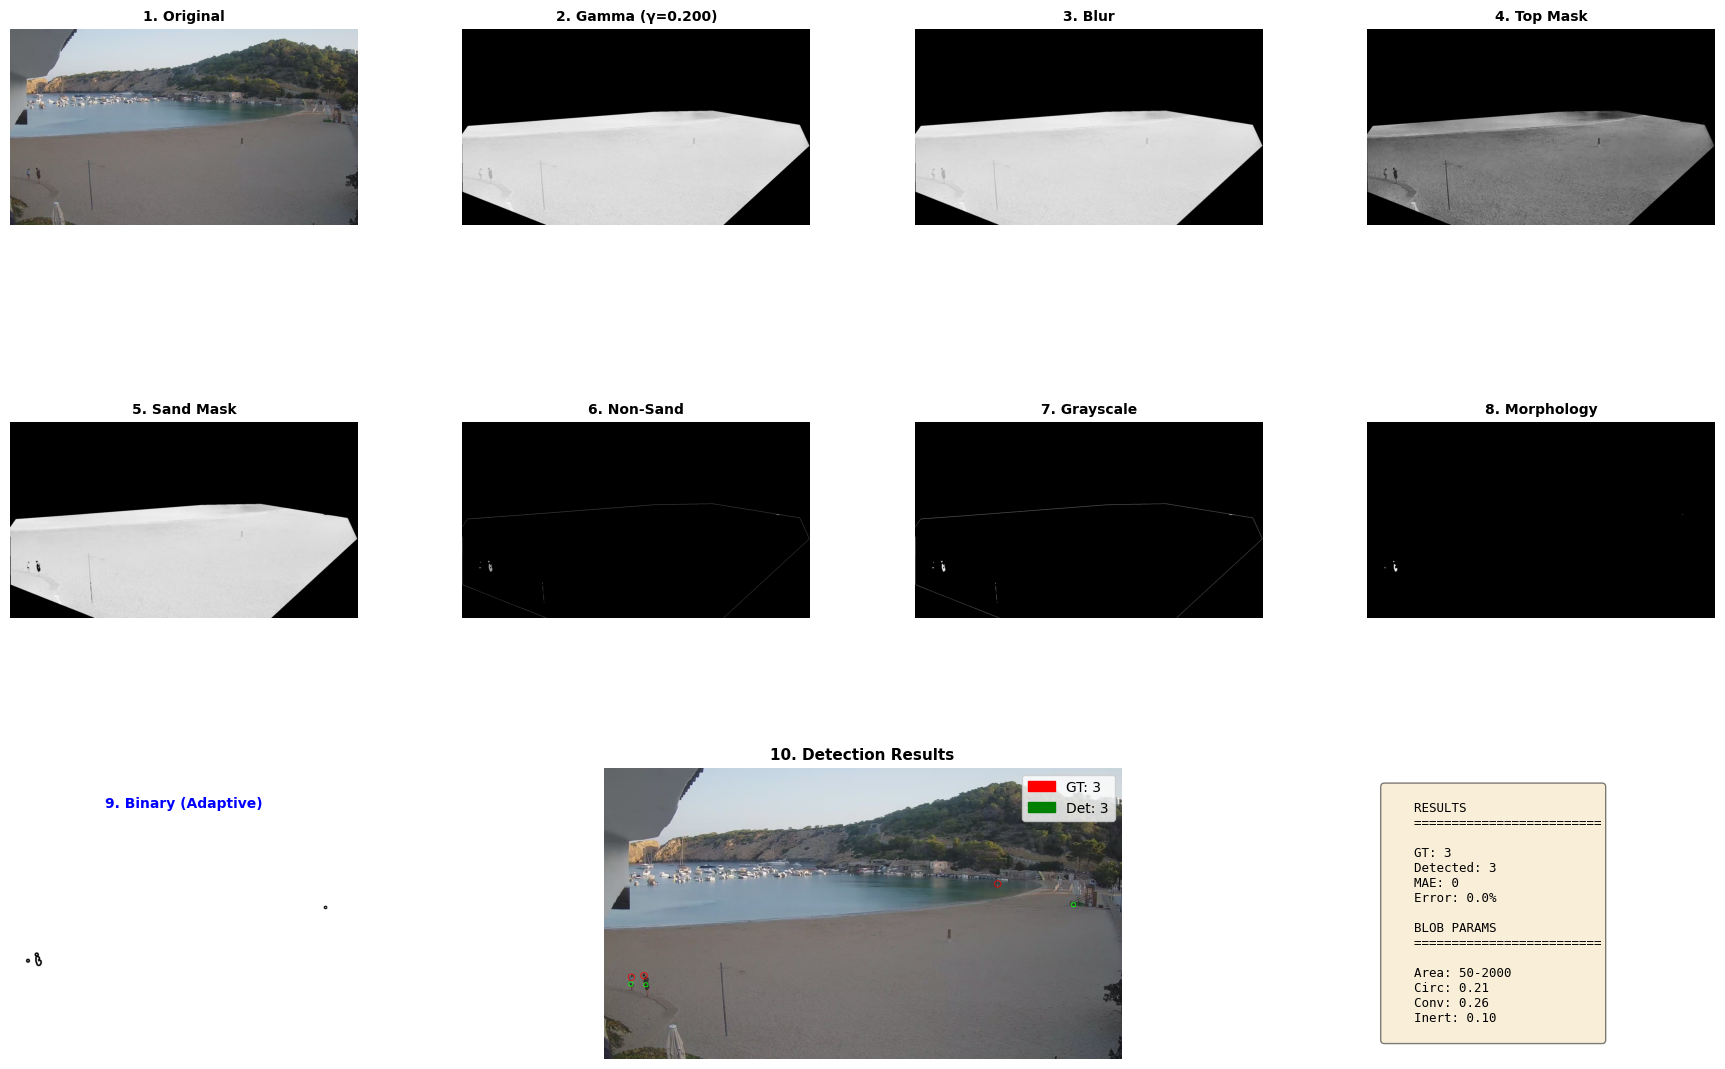


=== Processing: 1660287600.jpg ===


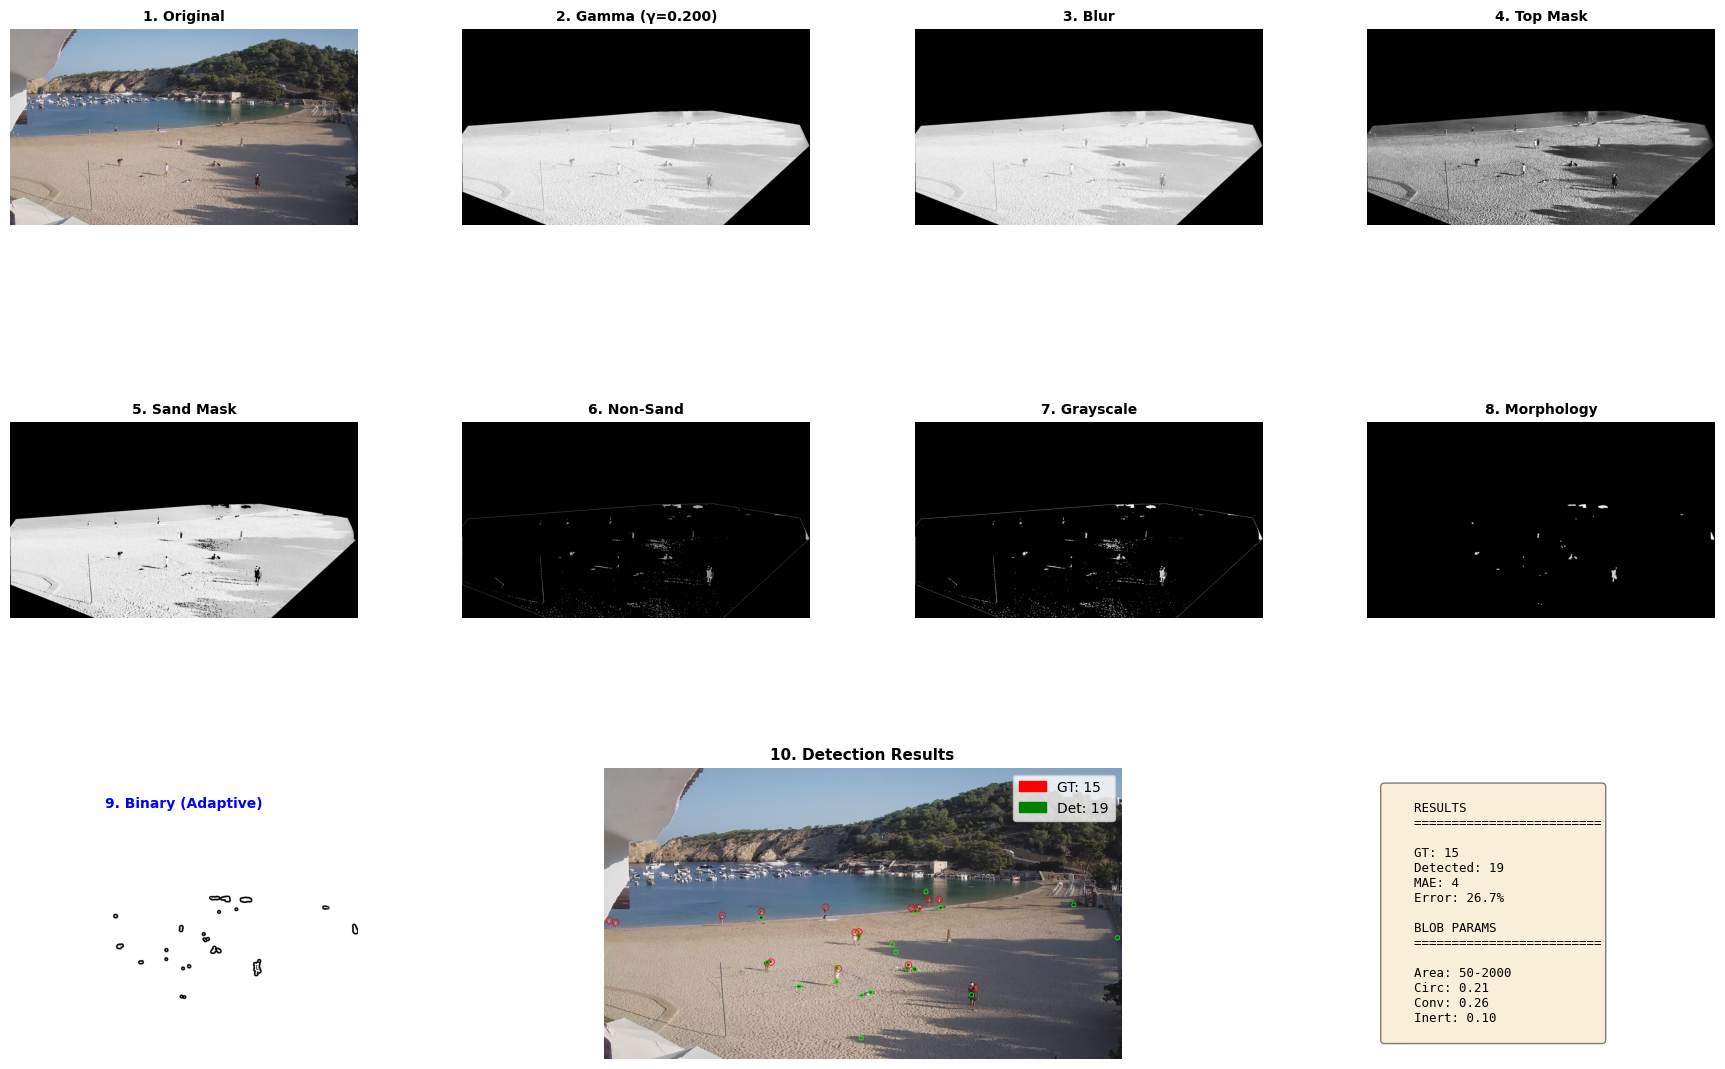


=== Processing: 1660291200.jpg ===


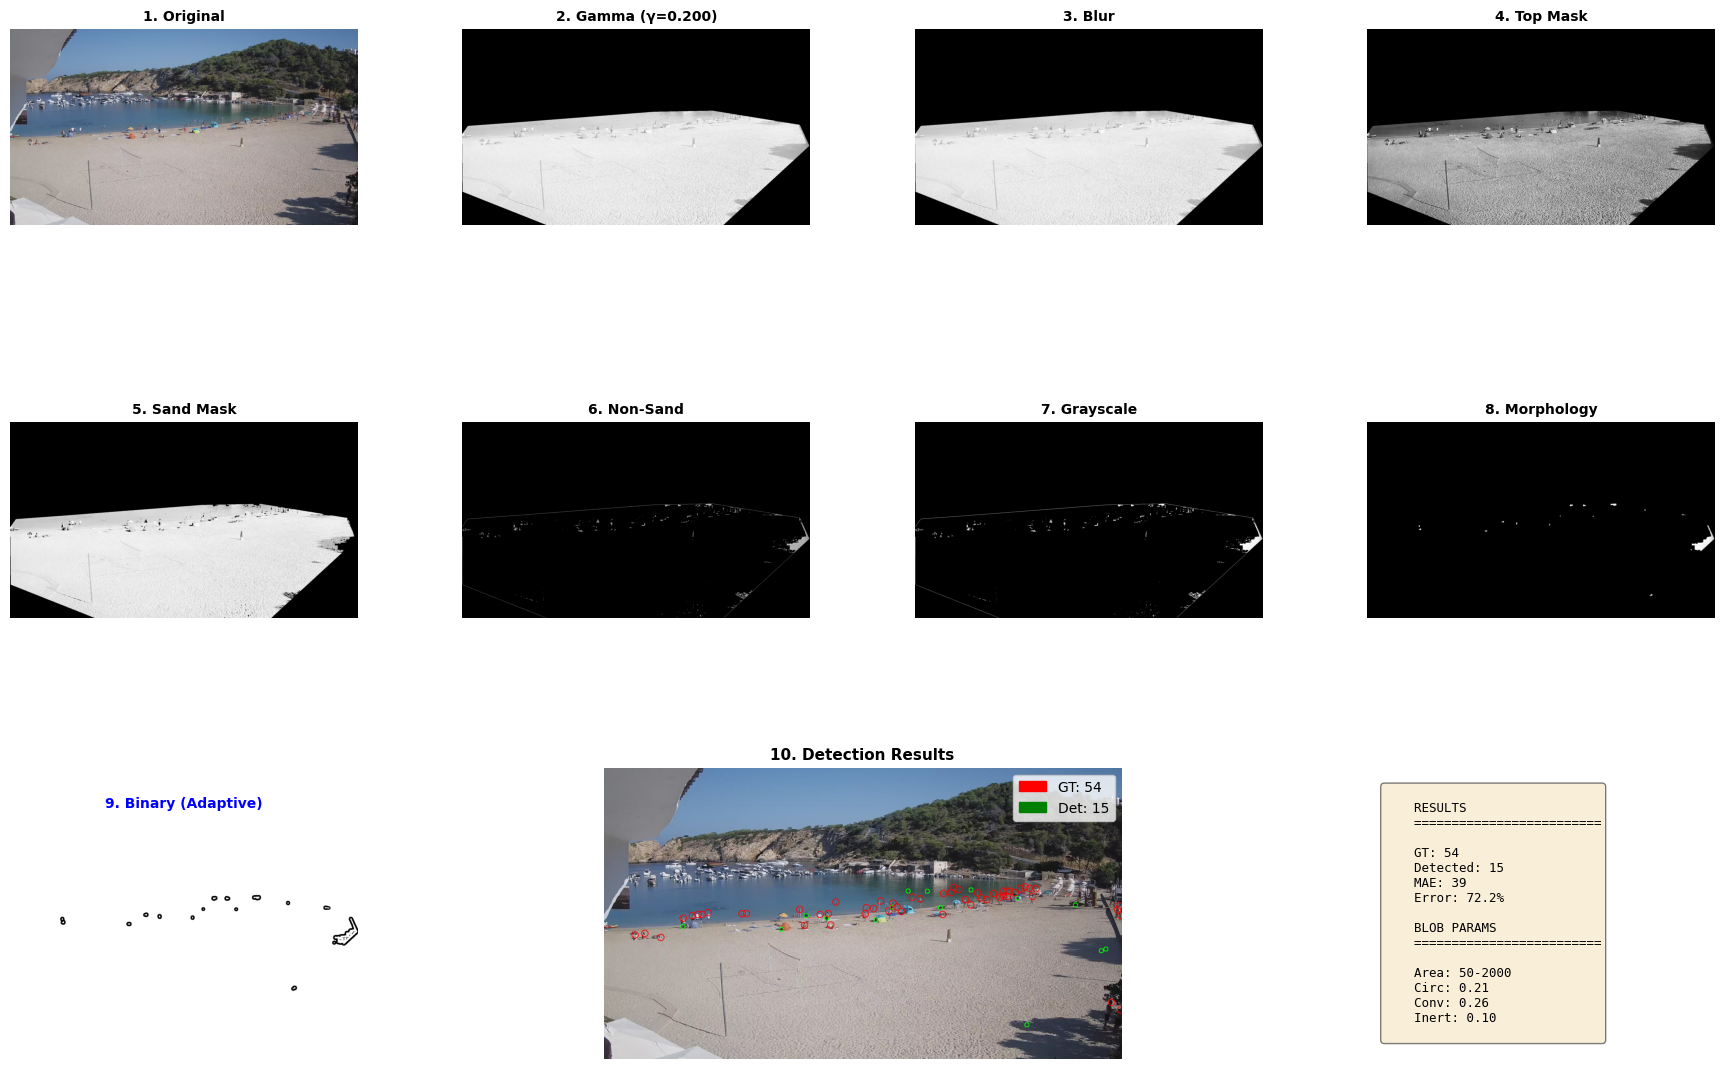


=== Processing: 1660294800.jpg ===


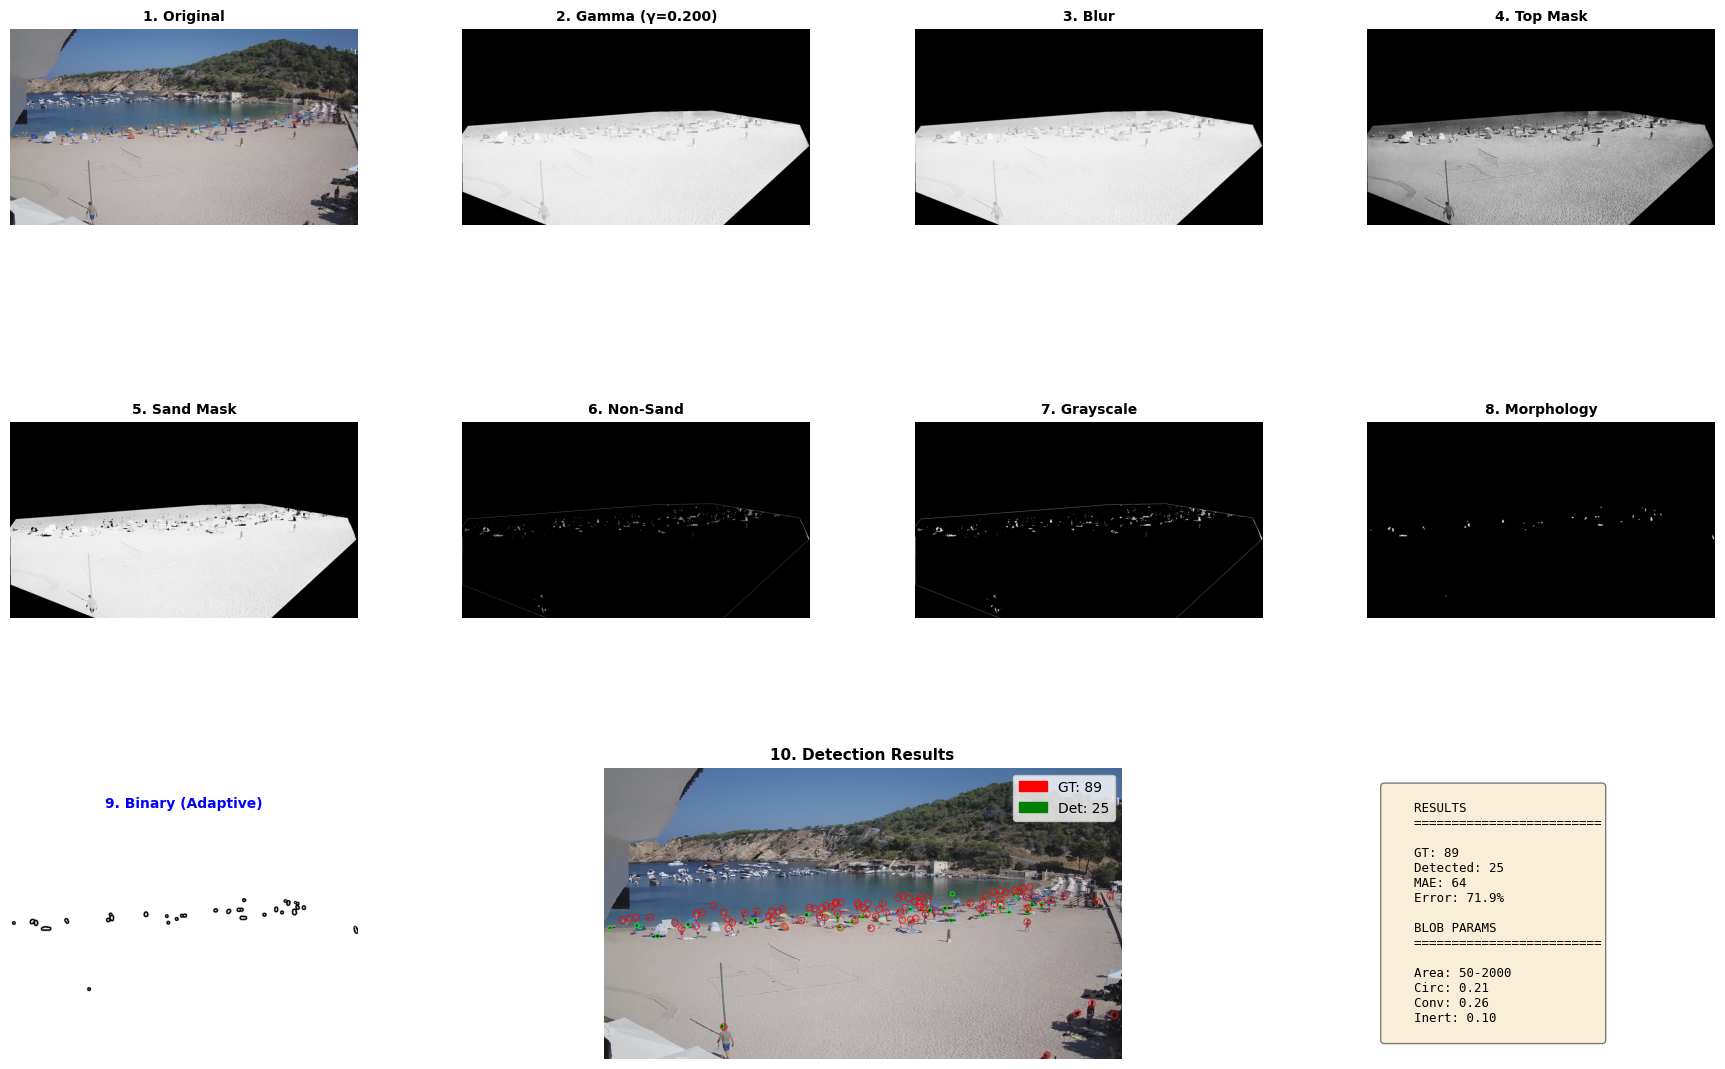


=== Processing: 1660298400.jpg ===


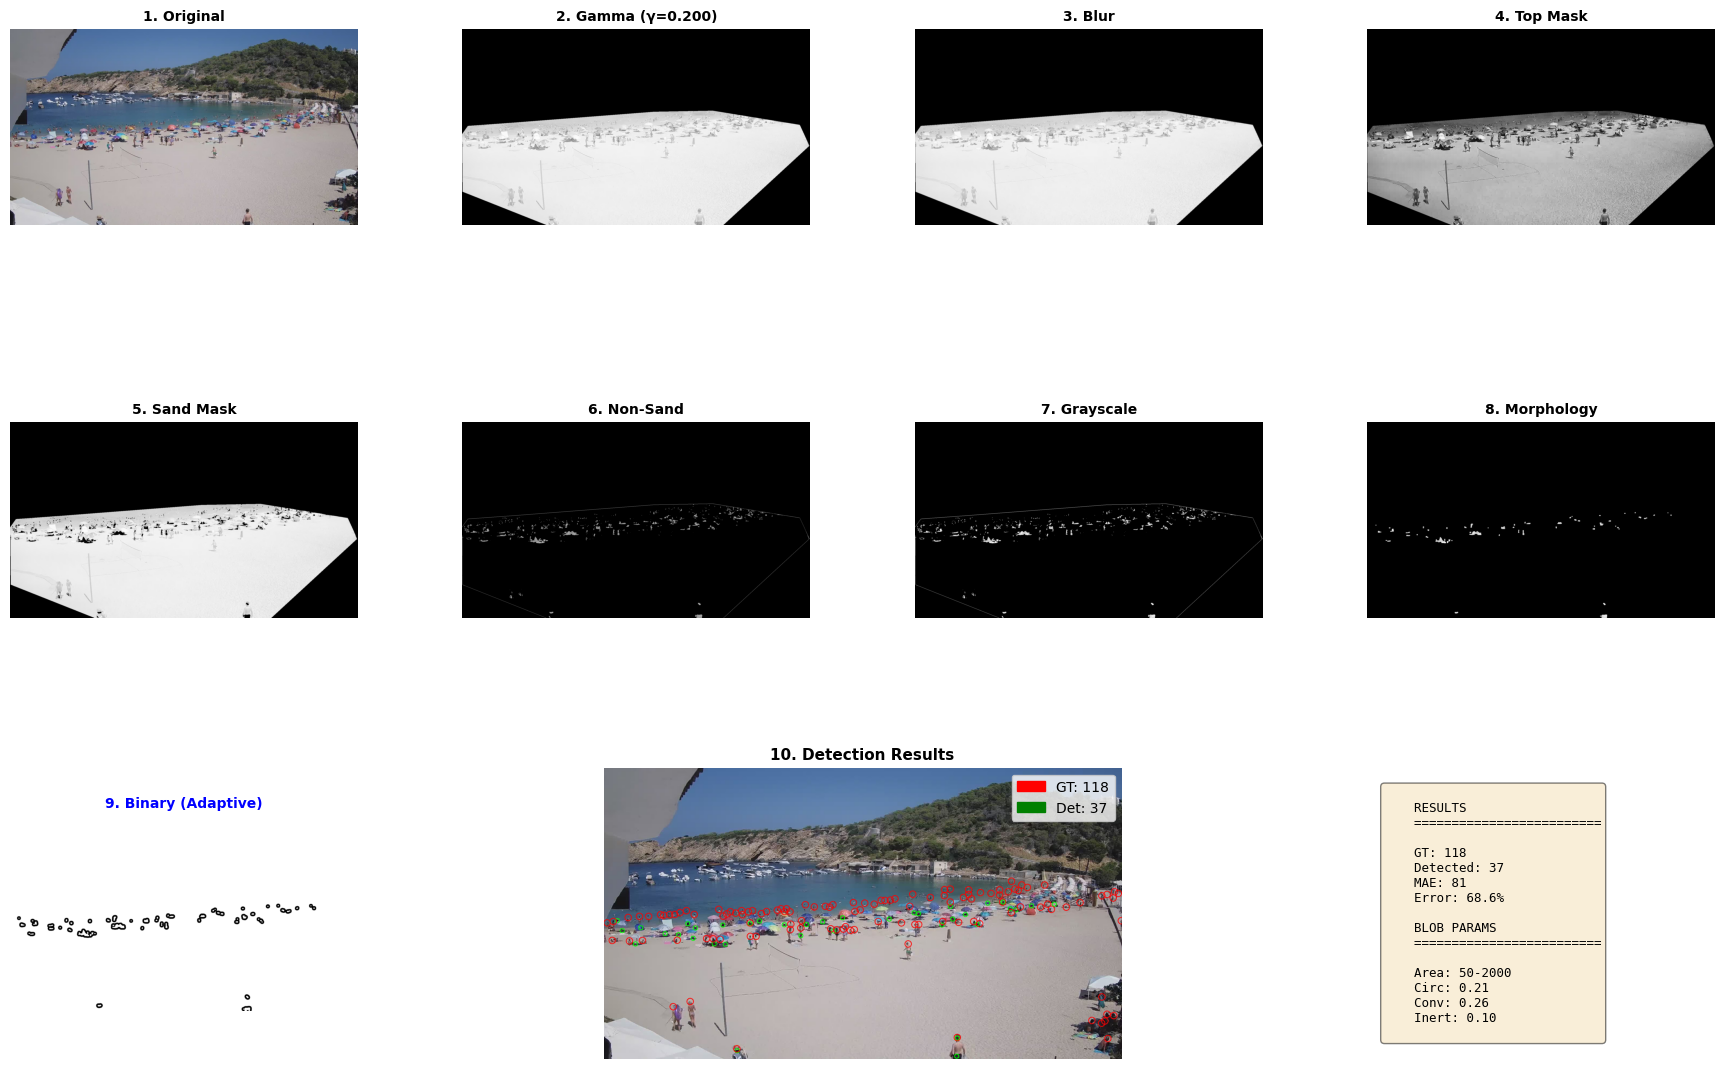


=== Processing: 1660302000.jpg ===


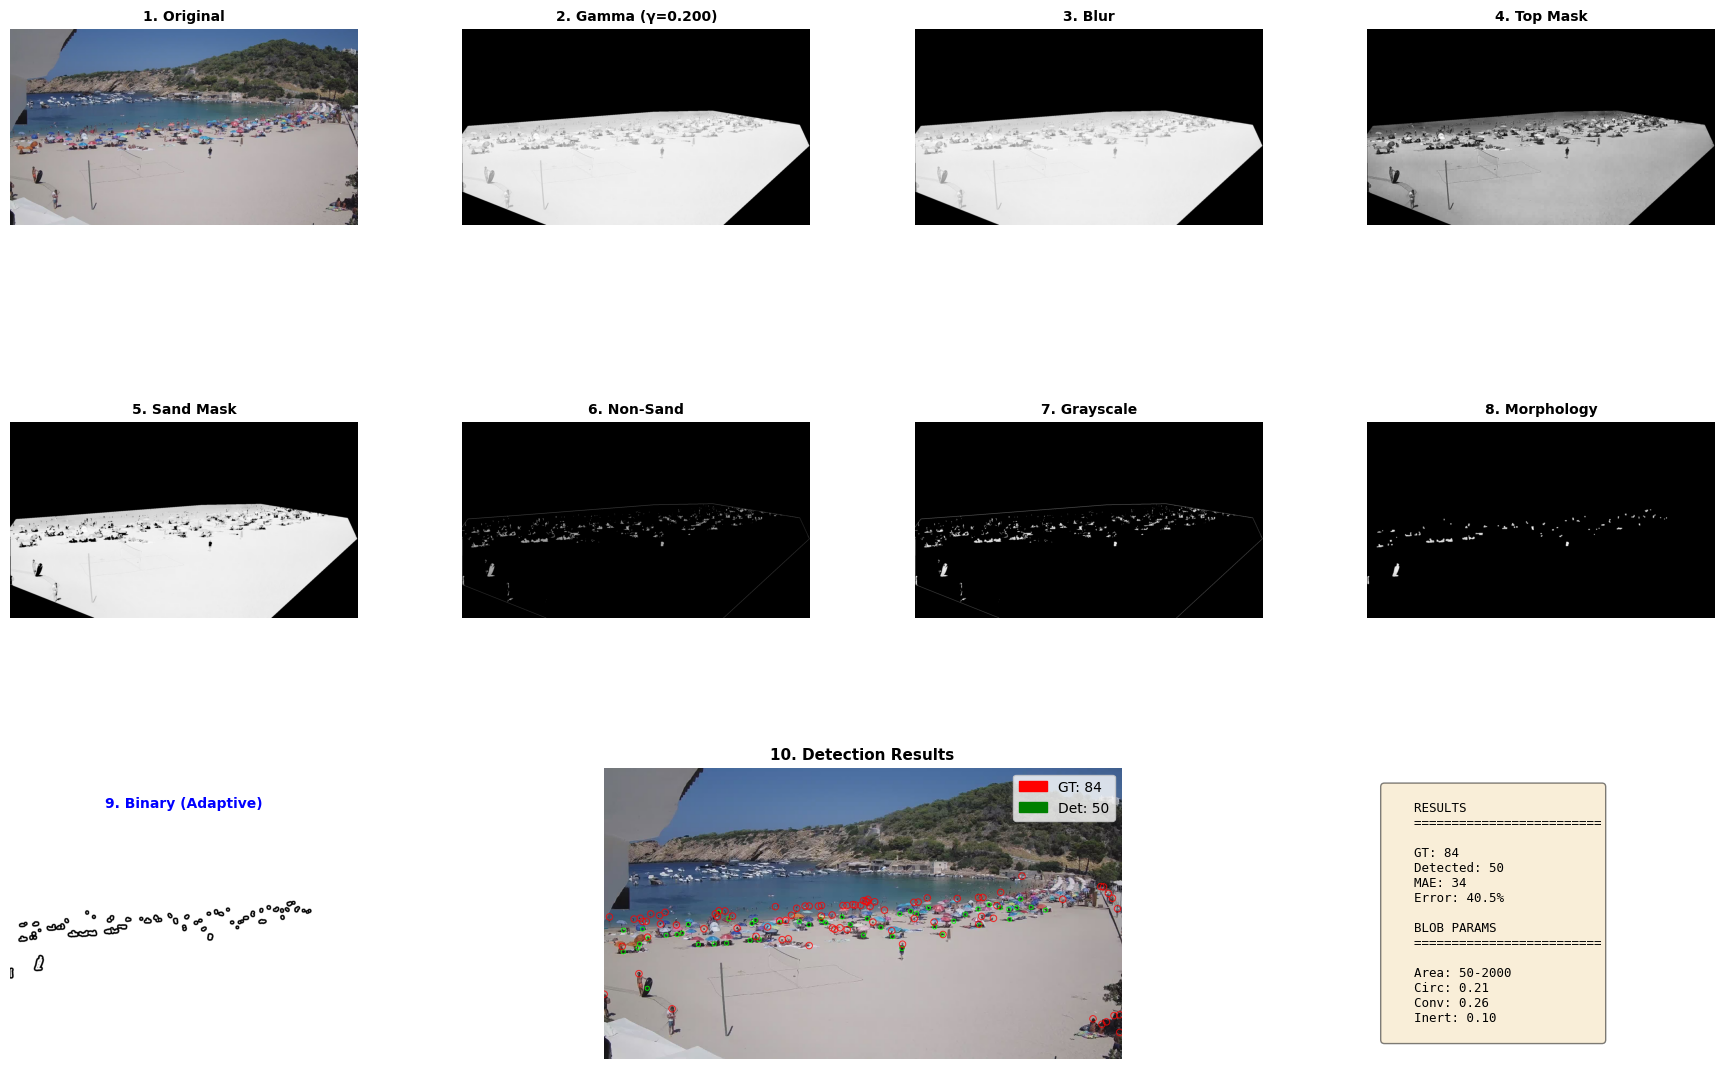


=== Processing: 1660305600.jpg ===


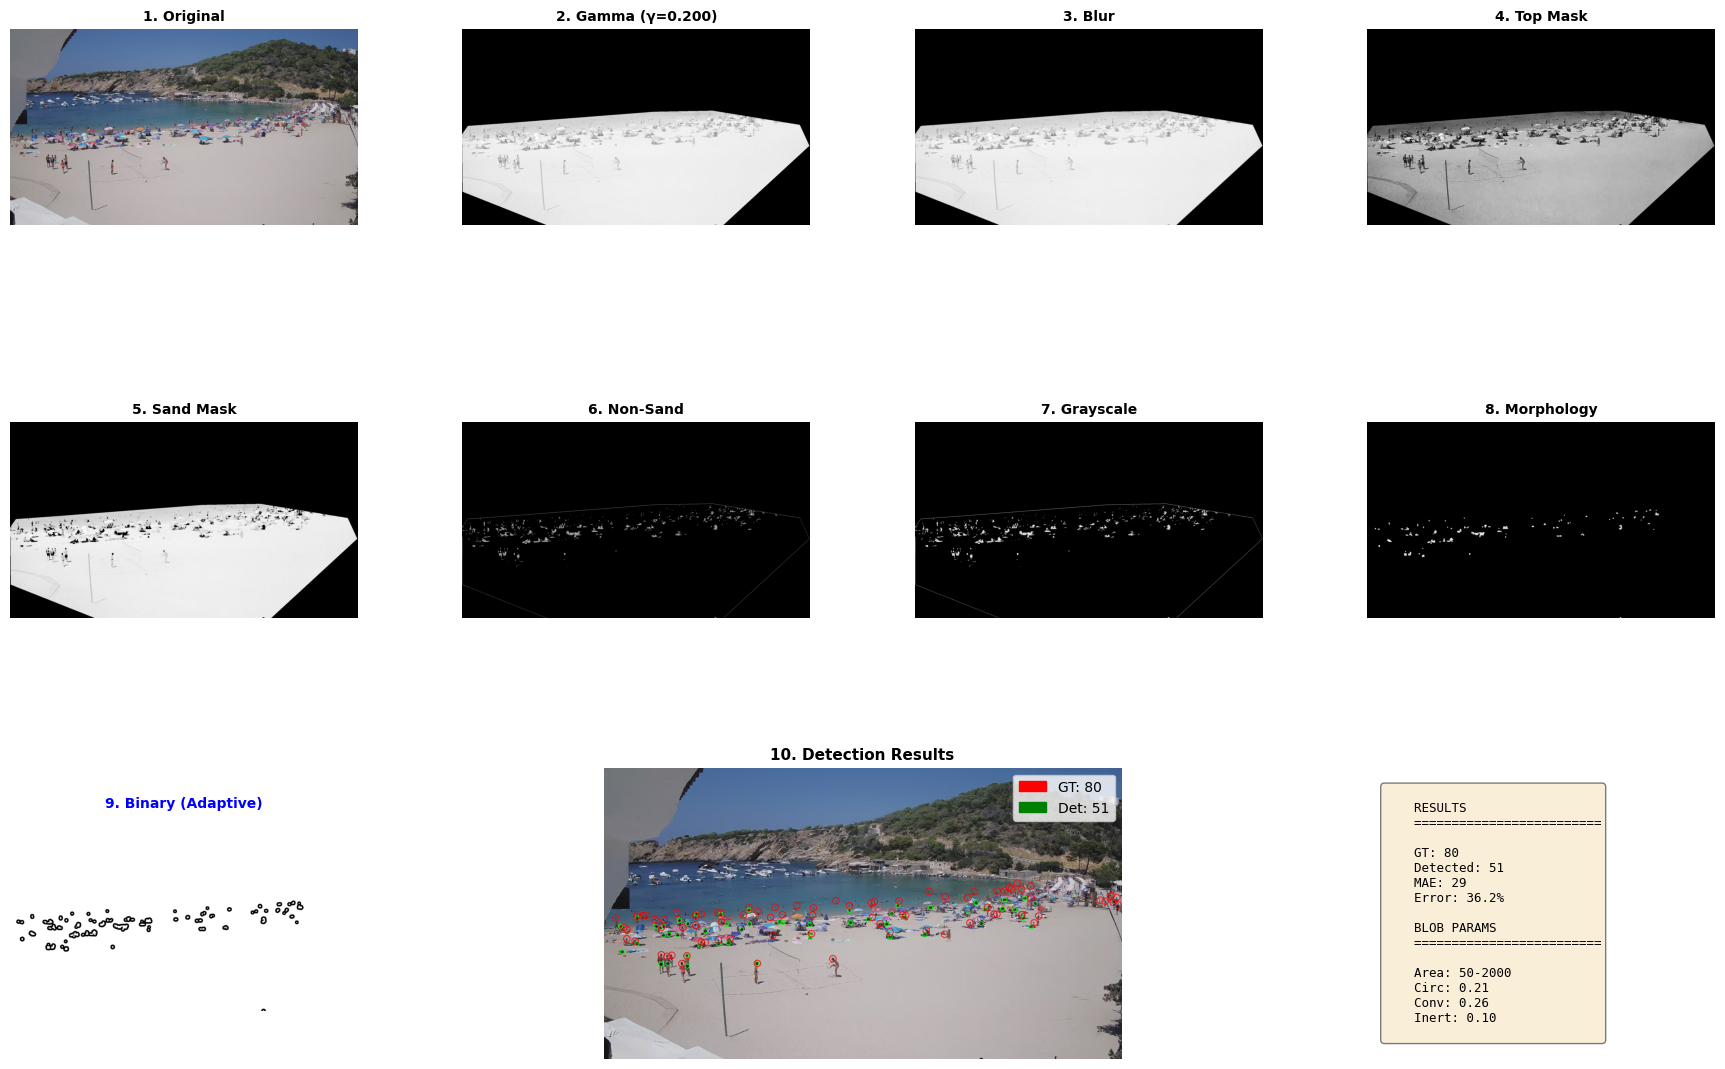


=== Processing: 1660309200.jpg ===


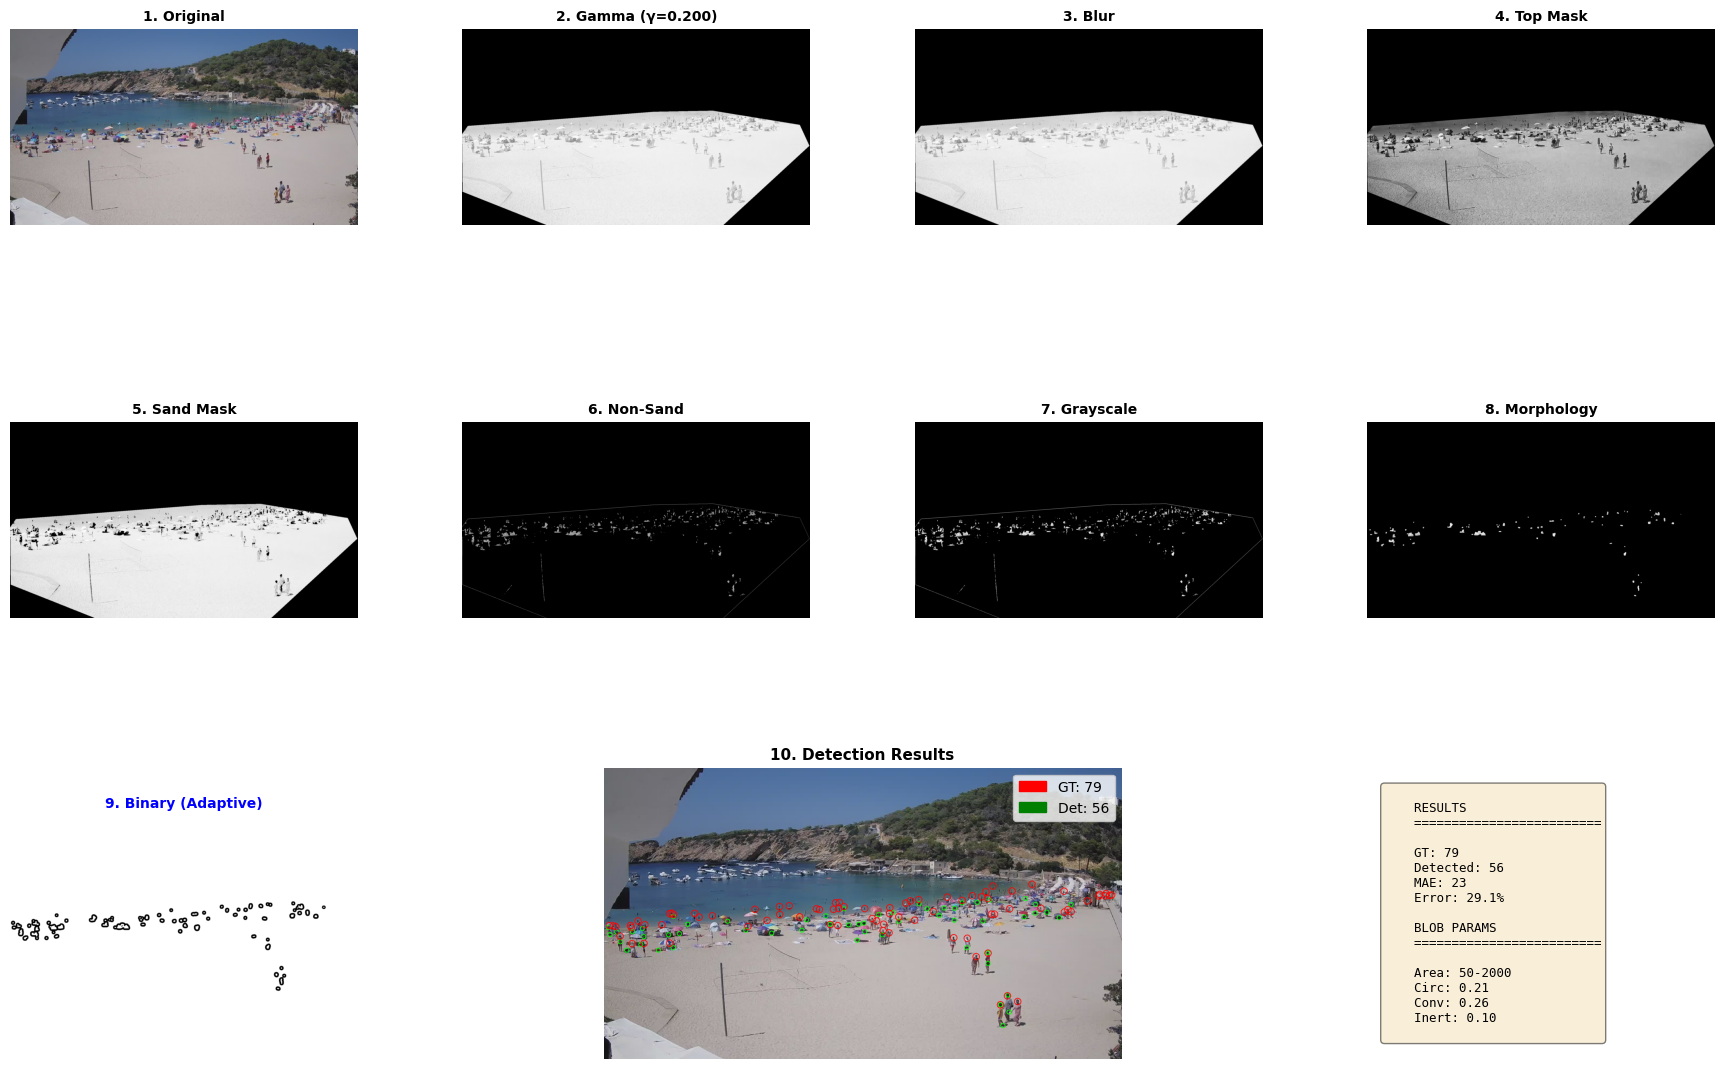


=== Processing: 1660316400.jpg ===


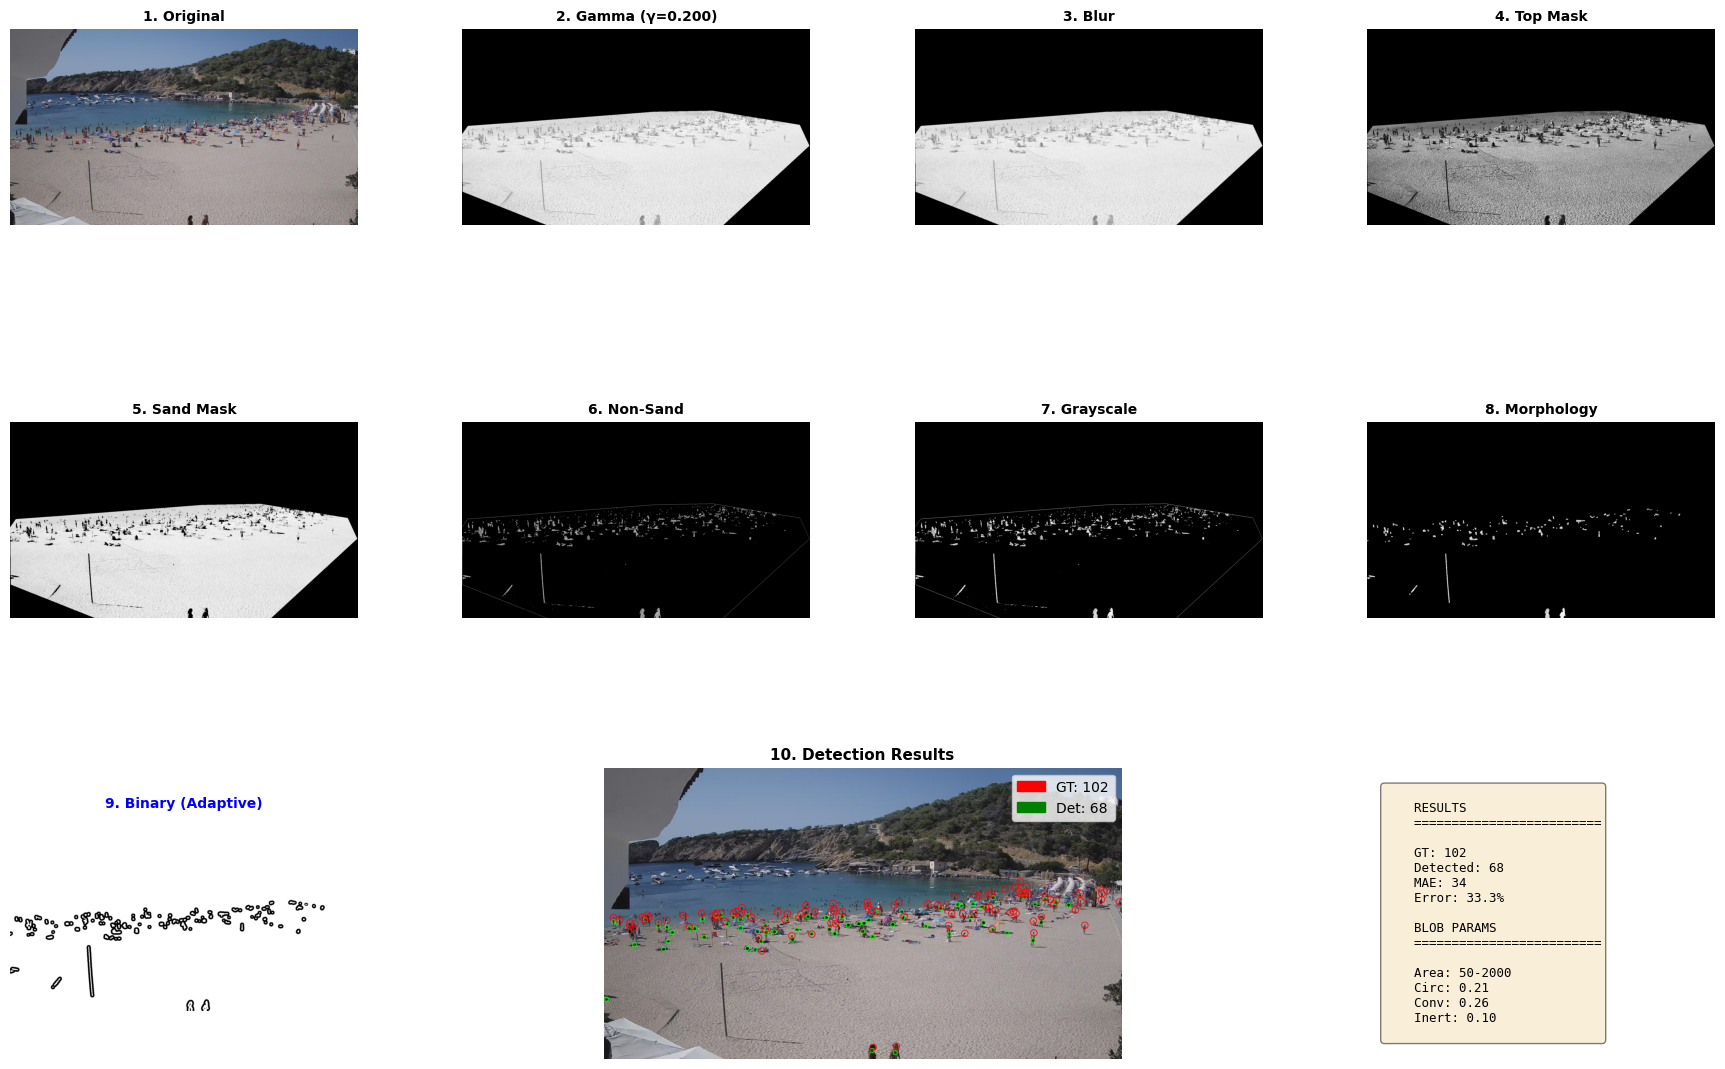


=== Processing: 1660320000.jpg ===


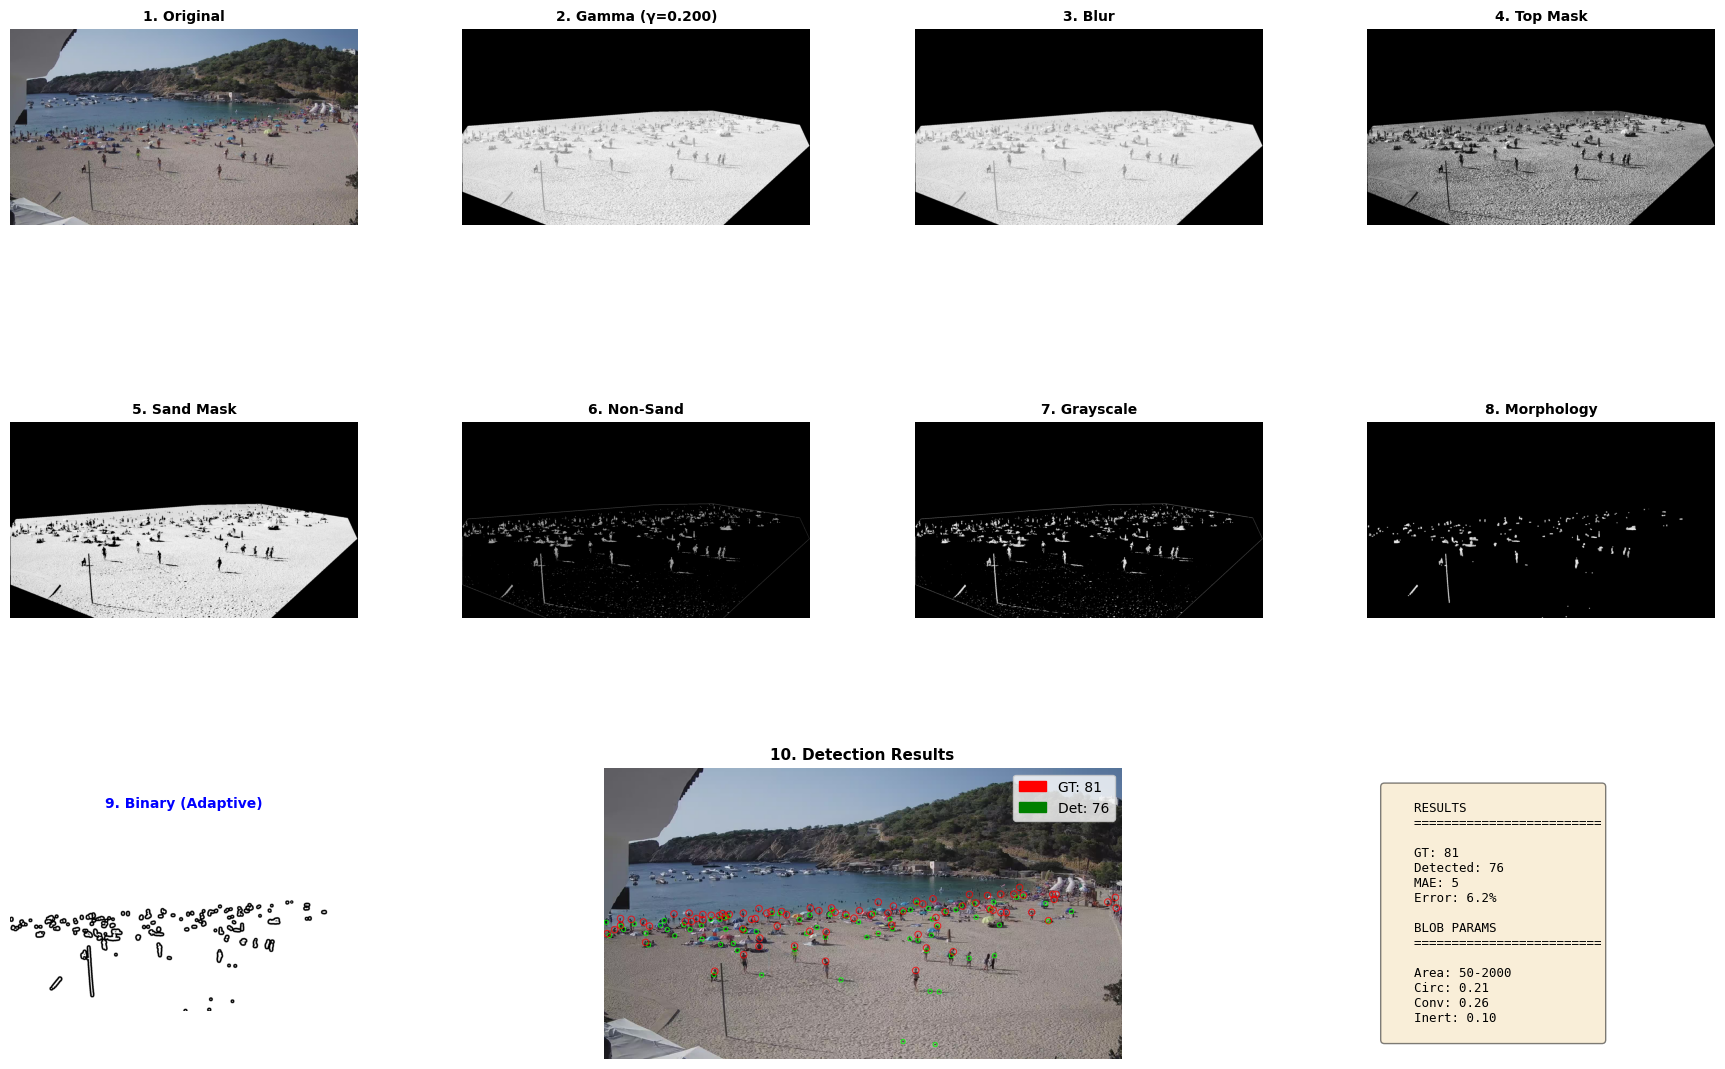

In [11]:
# Grab current values from the interactive UI
p = unified_interface.kwargs  
results = []

for img_file in image_files:
    print(f"\n=== Processing: {img_file} ===")
    res = comprehensive_analysis(
        img_file,
        target_brightness=p["target_brightness"],   
        clahe_clip=p["clahe_clip"],                 
        gaussian_size=int(p["gaussian_size"]),     
        adaptive_block_size=int(p["adaptive_block_size"]), 
        adaptive_c=p["adaptive_c"],              
        top_mask_percent=p["top_mask_percent"],    
        hsv_s_max=p["hsv_s_max"],                
        hsv_v_min=p["hsv_v_min"],                   
        morph_size=int(p["morph_size"]),            
        min_area=int(p["min_area"]),              
        max_area=int(p["max_area"]),              
        min_circularity=p["min_circularity"],     
        min_convexity=p["min_convexity"],           
        min_inertia=p["min_inertia"],              
        clear=False,
    )
    results.append(res)

# -------- Final report (unchanged) --------
if results:
    maes = np.array([r["mae"] for r in results], dtype=float)
    sq_errors = np.array([r["squared_error"] for r in results], dtype=float)
    error_percents = np.array([r["error_percent"] for r in results], dtype=float)

    mean_mae = maes.mean()
    mean_mse = sq_errors.mean()
    mean_error = error_percents.mean()

    display(HTML(f"""
    <div style="background-color:#34495e; color:black; padding:20px; border-radius:10px; margin-top:25px;">
        <h2 style="margin-top:0;">📑 Global Validation Report</h2>
        <table style="width:100%; color:black;">
            <tr><td><b>Images evaluated:</b></td><td>{len(results)}</td></tr>
            <tr><td><b>Image-level Mean MAE (|GT - Det|):</b></td><td>{mean_mae:.3f}</td></tr>
            <tr><td><b>Image-level Mean Squared Error (MSE):</b></td><td>{mean_mse:.3f}</td></tr>
            <tr><td><b>Mean error percentage:</b></td><td>{mean_error:.2f}%</td></tr>
        </table>
        <p style="margin-top:10px; font-size:13px; opacity:0.9;">
            MAE and MSE are computed on the people count per image (manual vs detected).
            Error percentage is the average |GT - Det| / GT across all images.
        </p>
    </div>
    """))
else:
    print("No results to summarize.")


## 9. 📖 Analytics Guide

### Understanding the Analytics:

#### Image Statistics:
- **Mean**: Average brightness (0-255). Lower = darker image
- **Std Dev**: Variation in brightness. Higher = more varied
- **Contrast**: Max - Min. Higher = more dynamic range
- **Entropy**: Image complexity. Higher = more textured/complex

### How to Use Analytics:

1. **Start with image statistics** → understand overall properties
2. **Check histograms** → see color distribution patterns
3. **Fine-tune blob parameters** → match detected people

### Otsu vs Adaptive Thresholding:

**Otsu (Automatic)**:
- ✓ No manual tuning needed
- ✓ Works well for bimodal histograms
- ✓ Fast and consistent
- ✗ Single global threshold
- ✗ Sensitive to lighting variations

**Adaptive (Local)**:
- ✓ Handles lighting variations
- ✓ Different threshold per region
- ✓ Better for complex scenes
- ✗ Requires parameter tuning
- ✗ Can be noisy

### Technique Selection:

**Use Otsu when:**
- Image has uniform lighting
- Clear separation between people and sand
- Histogram shows two distinct peaks

**Use Adaptive when:**
- Variable lighting (shadows, sun spots)
- Complex background patterns
- Need local contrast handling